In [ ]:
# Connect to Google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, DotProduct, ConstantKernel as C
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt

In [ ]:
# Load the data
fatigue_df = pd.read_csv("../Data_PI/Titanium_Alloy_PI.csv", encoding='latin1')
fatigue_df

,SL. Number,Number of Cycles,Stress (MPa),Solution Temperature (°C),Solution Time (hrs),Temperature Measurement (°C),Ann/Age. temp (cel),Ann/age time (hrs),Total Strain (%),R,...,N,O,H,Fe,Si,Sn,Nb,Mo,Zr,PI Fatigue Life
0,123,100000,860.00,932,0.0,25,704,2.0,0.0,0.5,...,0.0120,0.18,0.0000,0.20,0.00,0.0,0.0,0.0,0.0,1.199845e+05
1,126,100000,850.00,925,1.0,25,700,2.0,0.0,0.5,...,0.0120,0.18,0.0041,0.20,0.00,0.0,0.0,0.0,0.0,1.414165e+05
2,158,1000000,800.00,932,0.0,25,704,2.0,0.0,0.5,...,0.0120,0.18,0.0000,0.20,0.00,0.0,0.0,0.0,0.0,3.316557e+05
3,161,1000000,780.00,925,1.0,25,700,2.0,0.0,0.5,...,0.0120,0.18,0.0041,0.20,0.00,0.0,0.0,0.0,0.0,4.734918e+05
4,164,1000000,699.00,0,0.0,25,700,2.0,0.0,0.5,...,0.0130,0.19,0.0041,0.19,0.00,0.0,0.0,0.0,0.0,2.211821e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,18,249,915.24,1020,1.0,25,0,0.0,0.8,-1.0,...,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7,1.801202e+02
216,27,325,910.82,1020,1.0,25,0,0.0,0.8,-1.0,...,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7,2.168016e+02
217,31,370,907.55,1020,1.0,25,0,0.0,0.8,-1.0,...,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7,2.488141e+02
218,41,444,900.00,1020,1.0,25,0,0.0,0.8,-1.0,...,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7,3.426198e+02


In [ ]:
fatigue_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   SL. Number                    220 non-null    int64  
 1   Number of Cycles              220 non-null    int64  
 2   Stress (MPa)                  220 non-null    float64
 3   Solution Temperature (°C)     220 non-null    int64  
 4   Solution Time (hrs)           220 non-null    float64
 5   Temperature Measurement (°C)  220 non-null    int64  
 6   Ann/Age. temp (cel)           220 non-null    int64  
 7   Ann/age time (hrs)            220 non-null    float64
 8   Total Strain (%)              220 non-null    float64
 9   R                             220 non-null    float64
 10  Frequency (Hz)                220 non-null    float64
 11  Ti                            220 non-null    float64
 12  Al                            220 non-null    float64
 13  V    

In [ ]:
# Sort the data by ascending order of number of cycles
fatigue_df = fatigue_df.sort_values(by='Number of Cycles')

In [ ]:
from scipy import stats
def outliers(df1, level):

    # 1. temporary dataframe
    df = df1.copy(deep = True)

    # 2. Select a level for a Z-score to identify and remove outliers
    df_Z = df[(np.abs(stats.zscore(df)) < level).all(axis=1)]
    ix_keep = df_Z.index

    # 3. Subset the raw dataframe with the indexes you'd like to keep
    df_keep = df.loc[ix_keep]

    return(df_keep)

In [ ]:
# Removing Outliers
out_df = outliers(fatigue_df, 3)

In [ ]:
# Remove columns that are not needed
drop_cols = ['Number of Cycles','SL. Number']

# Use all remaining columns as features
features = out_df.drop(drop_cols, axis=1)

# Use log transform of the number of cycles as targets
targets = np.log10(out_df['Number of Cycles'])

# Display the features
features

,Stress (MPa),Solution Temperature (°C),Solution Time (hrs),Temperature Measurement (°C),Ann/Age. temp (cel),Ann/age time (hrs),Total Strain (%),R,Frequency (Hz),Ti,...,N,O,H,Fe,Si,Sn,Nb,Mo,Zr,PI Fatigue Life
184,1067.63,1020,1.0,25,700,2.0,1.25,-1.0,0.2,84.90,...,0.0025,0.00,0.004,0.0,0.340,4.00,0.70,0.500,3.70,1.428483e+02
79,685.38,1025,2.0,450,1025,2.0,1.00,0.0,0.0,85.01,...,0.0020,0.09,0.000,0.0,0.305,4.02,0.71,0.505,3.54,1.331221e+02
83,700.06,1025,2.0,400,1025,2.0,1.00,0.0,0.0,85.01,...,0.0020,0.09,0.000,0.0,0.305,4.02,0.71,0.505,3.54,9.944032e+01
81,711.56,1025,2.0,425,1025,2.0,1.00,0.0,0.0,85.01,...,0.0020,0.09,0.000,0.0,0.305,4.02,0.71,0.505,3.54,7.944426e+01
80,649.41,1025,2.0,500,1025,2.0,1.00,0.0,0.0,85.01,...,0.0020,0.09,0.000,0.0,0.305,4.02,0.71,0.505,3.54,2.796968e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,703.00,0,0.0,25,600,8.0,0.00,0.1,0.0,85.98,...,0.0040,0.03,0.008,0.0,0.000,1.95,0.00,2.000,3.80,2.137039e+07
42,947.76,0,0.0,25,800,2.0,0.00,0.1,6.0,84.83,...,0.0100,0.10,0.009,0.1,0.100,2.18,0.00,2.190,4.35,2.925415e+07
43,846.12,0,0.0,25,800,2.0,0.00,0.1,6.0,84.83,...,0.0100,0.10,0.009,0.1,0.100,2.18,0.00,2.190,4.35,5.087448e+07
39,695.53,0,0.0,25,800,2.0,0.00,0.1,6.0,84.83,...,0.0100,0.10,0.009,0.1,0.100,2.18,0.00,2.190,4.35,2.273788e+07


In [ ]:
# Convert the features into floats
features = features.astype('float64')

In [ ]:
# Calculate the coverage percentage of values within a specified range
def coverage(y, yL, yH):
    return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

Run # 1 Fold # 1


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Pearson CC: 0.9651856810147471
R2 score: 0.9283828206693122
RMSE: 0.43402586086087025
MAE: 0.29780616370758145
Coverage: 97.29729729729732
Pearson R2 median: 0.9651856810147471
R2 median: 0.9283828206693122
RMSE median: 0.43402586086087025
Interval Width: 1.6207221902257292
Composite Metric: 0.8839819522930434


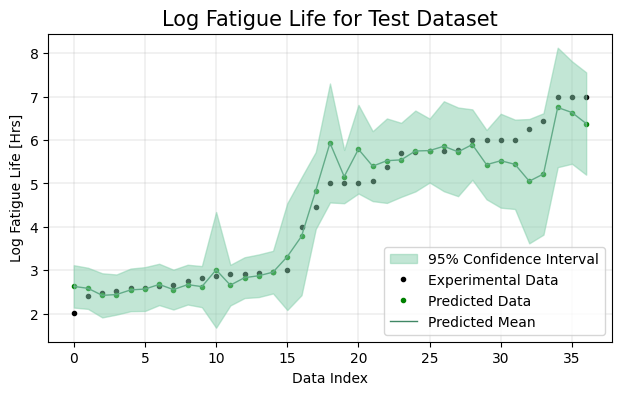

********************
Run # 1 Fold # 2


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Pearson CC: 0.9807187658489562
R2 score: 0.9615983928446032
RMSE: 0.31919461012107025
MAE: 0.23326705246073756
Coverage: 97.29729729729732
Pearson R2 median: 0.9807187658489562
R2 median: 0.9615983928446032
RMSE median: 0.31919461012107025
Interval Width: 1.2815964792051915
Composite Metric: 0.9247989297910805


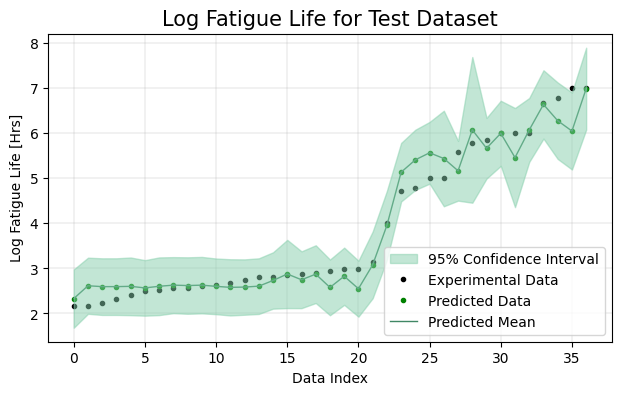

********************
Run # 1 Fold # 3
Pearson CC: 0.9629418483826068
R2 score: 0.9256644876293347
RMSE: 0.5074889306544995
MAE: 0.30934622361301917
Coverage: 89.18918918918922
Pearson R2 median: 0.9629418483826068
R2 median: 0.9256644876293347
RMSE median: 0.5074889306544995
Interval Width: 1.0026549610221114
Composite Metric: 0.9182569362017029


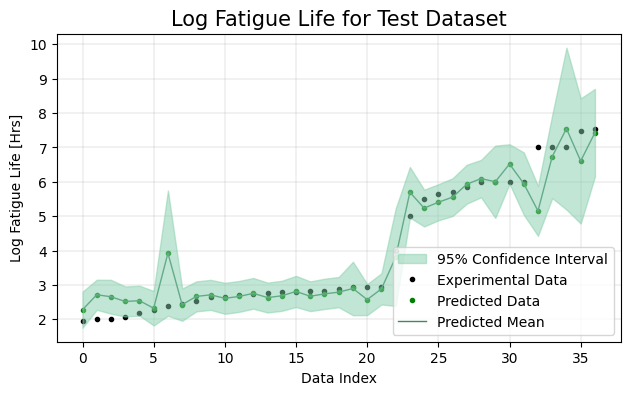

********************
Run # 1 Fold # 4


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Pearson CC: 0.9574241327248588
R2 score: 0.9076848222052242
RMSE: 0.5185629011728846
MAE: 0.3607719033380521
Coverage: 91.89189189189193
Pearson R2 median: 0.9574241327248588
R2 median: 0.9076848222052242
RMSE median: 0.5185629011728846
Interval Width: 1.0612205658735183
Composite Metric: 0.9247669833249623


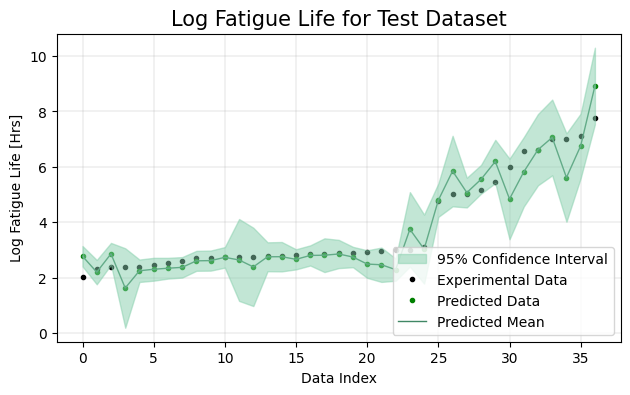

********************
Run # 1 Fold # 5
Pearson CC: 0.9477537119401349
R2 score: 0.8924899966527682
RMSE: 0.566275296026325
MAE: 0.3220172884163953
Coverage: 86.48648648648651
Pearson R2 median: 0.9477537119401349
R2 median: 0.8924899966527682
RMSE median: 0.566275296026325
Interval Width: 1.2629350338721697
Composite Metric: 0.8466002402150794


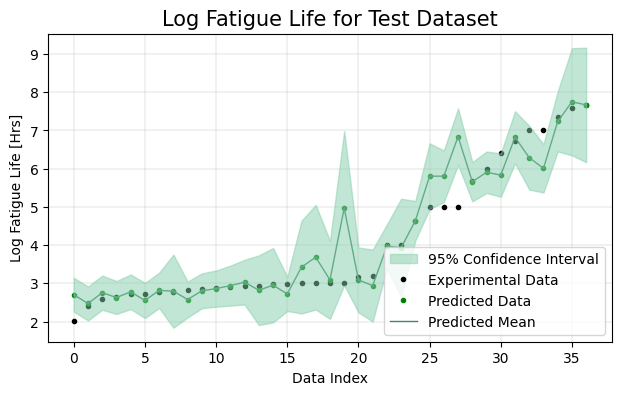

********************


In [ ]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        kernel = C(1.0) * Matern(length_scale=1.0) + WhiteKernel(noise_level=1.0) + C(1.0) * DotProduct(sigma_0=1.0)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            X_train, X_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets.iloc[tr], targets.iloc[ts]

            scale = MinMaxScaler()
            X_train = scale.fit_transform(X_train)
            X_test = scale.transform(X_test)

            model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=8, normalize_y=True)

            model.fit(X_train, y_train)

            mu_z, std_z = model.predict(X_test, return_std=True)
            y_pred_test = mu_z
            y_pred_unc_test = std_z

            PearsonCC[j, i] = pearsonr(y_test, y_pred_test)[0]
            R2_score[j, i] = r2_score(y_test, y_pred_test)
            RMSE[j, i] = sqrt(mean_squared_error(y_pred_test, y_test))
            MAE[j, i] = np.mean(abs(y_pred_test-y_test))

            df_test_low = y_pred_test - 2 * y_pred_unc_test
            df_test_median = y_pred_test
            df_test_high = y_pred_test + 2 * y_pred_unc_test

            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high)

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')
            print(f'Coverage: {test_coverage[j, i]}')

            print(f"Pearson R2 median: {pearsonr(y_test, df_test_median)[0]}")
            print(f"R2 median: {r2_score(y_test, df_test_median)}")
            print(f"RMSE median: {np.sqrt(mean_squared_error(y_test, df_test_median))}")

            # Prediction interval width
            # Quantifies the average width of the prediction intervals. Smaller widths suggest more precise uncertainty estimates.

            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            y_pred = y_pred_test
            y_std = y_pred_unc_test
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]
            ## Uncertainty quantification plot
            ax[0].fill_between(iteration_list, np.squeeze(y_pred) - 2*np.squeeze(y_std), np.squeeze(y_pred) + 2*np.squeeze(y_std), alpha=0.5, color='#86cfac', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test, 'ko', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, np.squeeze(y_pred), 'go', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="#408765", label="Predicted Mean")
            ax[0].legend(loc=4, fontsize=10, frameon=True)
            ax[0].set_xlabel("Data Index", fontsize=10)
            ax[0].set_ylabel("Log Fatigue Life [Hrs]", fontsize=10)
            ax[0].set_title("Log Fatigue Life for Test Dataset", fontsize=15)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')
            fig.delaxes(ax[1])

            plt.show()

            print(20*'*')

In [ ]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten(), 'Coverage': test_coverage.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE,Coverage
0,0.965186,0.928383,0.434026,0.297806,97.297297
1,0.980719,0.961598,0.319195,0.233267,97.297297
2,0.962942,0.925664,0.507489,0.309346,89.189189
3,0.957424,0.907685,0.518563,0.360772,91.891892
4,0.947754,0.892490,0.566275,0.322017,86.486486


In [ ]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)
test_coverage_mean = np.mean(test_coverage)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)
test_coverage_std = np.std(test_coverage)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std, 'Test Coverage Mean': test_coverage_mean, 'Test Coverage Std':test_coverage_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std,Test Coverage Mean,Test Coverage Std
0,0.962805,0.01079,0.923164,0.0232,0.46911,0.086099,0.304642,0.041511,92.432432,4.324324


In [ ]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(),  'Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Interval Width,Composite Metric
0,97.297297,1.620722,0.883982
1,97.297297,1.281596,0.924799
2,89.189189,1.002655,0.918257
3,91.891892,1.061221,0.924767
4,86.486486,1.262935,0.846600


In [ ]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)
median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)
median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std,
                    'Interval Width Mean': median_interval_width_mean, 'Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Interval Width Mean,Interval Width Std,Composite Metric Mean,Composite Metric Std
0,92.432432,4.324324,1.245826,0.216947,0.899681,0.030559
